In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date as date
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

### Explore Database

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Using the inspector to print the column names within the 'Measurement' table and its types
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


### Reflect Database

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Query for the latest date in Measurement table
latest_date = session.query(func.max(Measurement.date)).all()
# latest_date

# Using list comprehension, converting list of tuple to list of list, and selecting first item, in this case only item, making it a str. 
latest_date_ls = [list(item) for item in latest_date][0]
latest_date_ls = latest_date_ls[0]
latest_date_ls

'2017-08-23'

In [13]:
earliest_date = session.query(func.min(Measurement.date)).all()
earliest_date

[('2010-01-01')]

In [14]:
# Making latest_date a datetime object for future use
# latest_date_ls2 = date1.fromisoformat(latest_date_ls)
# type(latest_date_ls2)

In [15]:
# Query for date, 12 months before latest_date in Measurement table
last_year= dt.date(2017,8,23) - dt.timedelta(days=365)
last_year

datetime.date(2016, 8, 23)

In [16]:
# Query to retrieve the last 12 months of precipitation data
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).all()
# precip

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns=['Date', 'Precipitation'])
precip_df = precip_df.dropna(how='any')
precip_df.set_index('Date', inplace=True, )
# precip_df.head()

In [18]:
# Sort the dataframe by date
precip_df = precip_df.sort_values(by = 'Date')
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


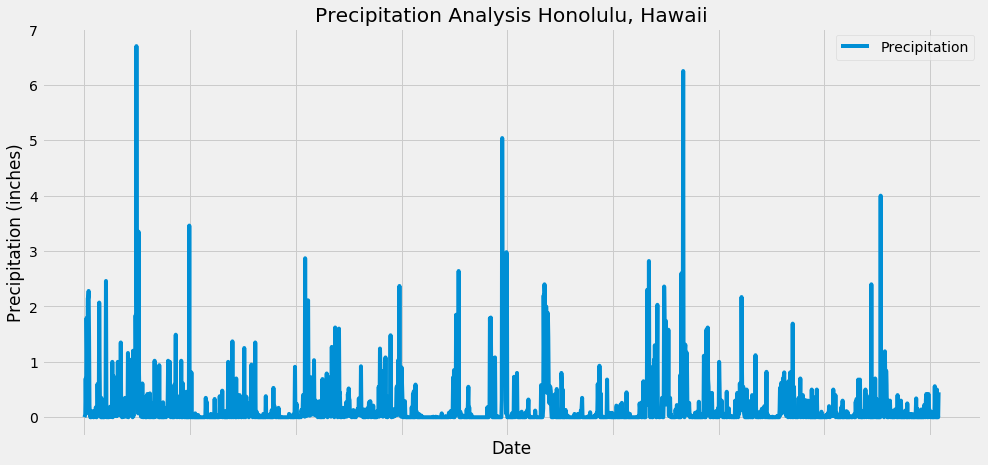

In [19]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax, x_compat = True)

# Set label and title
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (inches)")
ax.set_title("Precipitation Analysis Honolulu, Hawaii")

ax.tick_params(axis='x', 
               bottom=False,      # ticks along the bottom edge are off
               labelbottom=False) # labels along the bottom edge are off

# Saving and plotting figure
plt.grid(which='major', axis='both', linestyle='-')
plt.savefig("Graph_Images/1_Precipitation_Analysis.png")
plt.show()


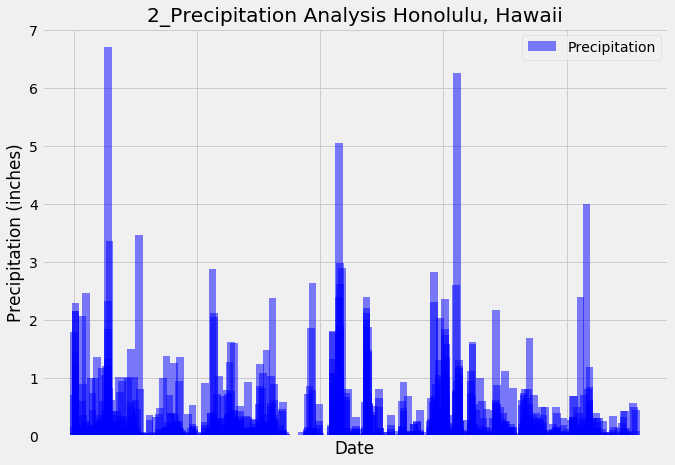

In [20]:
# Second option to plot the dataframe as a horizontal bar chart using pandas plotting

#Setting x and y axes lists to use for plotting
x = precip_df.index.tolist()
y = precip_df['Precipitation'].tolist()

# Plotting dataframe bar chart, adding width=5 to enlgarge bars
plt.figure(figsize=(10,7))
plt.bar(x,y,width=5,color='b', alpha=0.5, align="center",label='Precipitation')

#Setting title of chart, and x,y labels
plt.title("2_Precipitation Analysis Honolulu, Hawaii")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.legend()

# Setting tick_params in place, removing bottom edge off, and x-axis labels
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)
plt.grid(which='major', axis='both', linestyle='-')

# Saving as image and displaying chart
plt.savefig("Graph_Images/2_Precipitation_Analysis.png")
plt.show()


In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
# Joining the data from the station columns of the two tables into one single dataset, in order to obtain a distnct count of the stations.

station_count = session.query(Measurement.station, Station.station).\
    filter(Measurement.station == Station.station).distinct().count()

print(f"There are {station_count} stations in the dataset.")

There are 9 stations in the dataset.


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Station.station, func.count(Measurement.station)).\
            filter(Measurement.station == Station.station).\
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
for station in active_stations:
    print(f"Station: {station[0]}\tCount: {station[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

top_active_station = active_stations[0][0]
temp_top_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == top_active_station).all()
temp_top_station

[(54.0, 85.0, 71.66378066378067)]

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_top_station = session.query(Measurement.tobs).\
        filter(Measurement.date >= last_year).\
        filter(Measurement.date <= latest_date_ls).\
        filter(Measurement.station == top_active_station).all()
# tobs_top_station

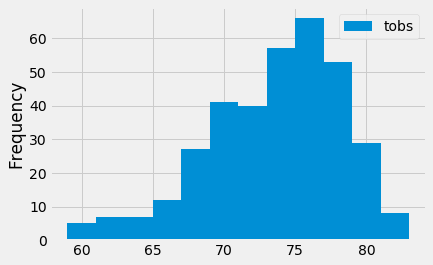

<Figure size 432x288 with 0 Axes>

In [27]:
# Unpacking list, and saving it to tobs_list variable to use for plotting
tobs_list= np.concatenate(tobs_top_station).ravel().tolist()
# print(tobs_list)

# Plotting restults in histogram
fig = plt.figure()
plt.hist(tobs_list, bins=12 , label='tobs')
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.show()
plt.savefig("Graph_Images/Station_USC00519281_Analysis.png")

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
   
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
# Function to calculate temps for my vacation days, storing in variable for later retrieval 
my_vacay_dates = calc_temps('2017-02-18', '2017-02-26')

# Using np.ravel method to unpack my_vacay_list, from tuple into a list to use for plotting.
my_vacay_dates = list(np.ravel(my_vacay_dates))
my_vacay_dates

[61.0, 69.5576923076923, 75.0]

In [30]:
# Obtaining from my_vacay_dates list (tmin, tmax, tavg) and storing in seperate variables
tmin = my_vacay_dates[0]
tmax = my_vacay_dates[2]
tavg = my_vacay_dates[1]

print(f"Lowest Temperature: {tmin}")
print(f"Highest Temperature: {tmax}")
print(f"Average Temperature: {round(tavg, 3)}")

Lowest Temperature: 61.0
Highest Temperature: 75.0
Average Temperature: 69.558


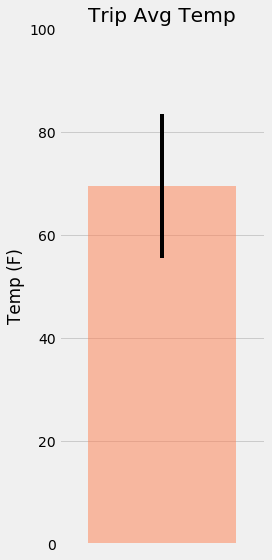

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Plotting results as a bar chart
fig, ax = plt.subplots(figsize=plt.figaspect(2.))

bar= ax.bar(1, tavg, yerr=(tmax-tmin),alpha=0.5, color="coral")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel = "Temp (F)")
ax.margins(.2,.2)
fig.tight_layout()

plt.savefig("Graph_Images/Temperature_Analysis.png")
plt.show()

In [32]:
# Storing my trip dates into variables, using most recent year from database provided
start_date = '2017-02-18'
end_date = '2017-02-26'

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
condition1 = and_(Measurement.station == Station.station)
total_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
                    func.sum(Measurement.prcp)).join(Station, condition1).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()
# total_rainfall

In [33]:
# Load into Pandas Dataframe for better visualization of my vacation trip dates 
total_rainfall_df = pd.DataFrame(total_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Total Precipitation (in.)'])
total_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Total Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.61
1,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.17
2,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.16
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.15
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.14
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.11
6,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.06


## Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# My trip dates, using historic data matching
start_date = '2017-02-18'
end_date = '2017-02-26'

# Use the start and end date to create a range of dates
trip_dates2 = pd.date_range(start=start_date, end=end_date,freq='D').strftime('%Y-%m-%d').tolist()

# Creating a date range, stripping off the year and saving to a list of %m-%d strings
trip_dates = pd.date_range(start=start_date, end=end_date,freq='D').strftime('%m-%d').tolist()

In [36]:
trip_dates

['02-18',
 '02-19',
 '02-20',
 '02-21',
 '02-22',
 '02-23',
 '02-24',
 '02-25',
 '02-26']

In [37]:
# Loop through the list of %m-%d strings and calculate the normals for each date, storing in variable normals
normals = []
for date in trip_dates:
    normals.append(list(np.ravel(daily_normals(date))))

normals

[[63.0, 70.79629629629629, 77.0],
 [60.0, 69.33962264150944, 77.0],
 [63.0, 70.14035087719299, 76.0],
 [63.0, 69.79629629629629, 76.0],
 [60.0, 70.15789473684211, 83.0],
 [62.0, 70.35593220338983, 81.0],
 [61.0, 68.56666666666666, 76.0],
 [61.0, 68.59649122807018, 76.0],
 [62.0, 69.89285714285714, 78.0]]

In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temps_df = pd.DataFrame(normals, columns = ['Tmin', 'Tavg', 'Tmax'])
trip_temps_df["Date"] = trip_dates2
trip_temps_df = trip_temps_df.set_index("Date")
trip_temps_df

,Tmin,Tavg,Tmax
Date,,,
2017-02-18,63.0,70.796296,77.0
2017-02-19,60.0,69.339623,77.0
2017-02-20,63.0,70.140351,76.0
2017-02-21,63.0,69.796296,76.0
2017-02-22,60.0,70.157895,83.0
2017-02-23,62.0,70.355932,81.0
2017-02-24,61.0,68.566667,76.0
2017-02-25,61.0,68.596491,76.0
2017-02-26,62.0,69.892857,78.0


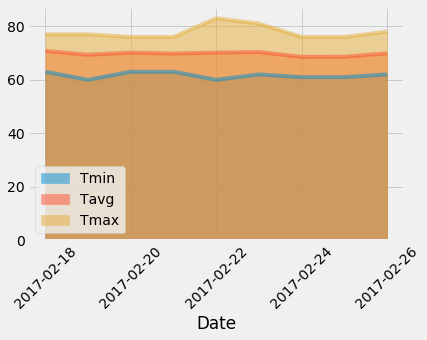

In [39]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temps_df.plot.area(stacked=False)
plt.xticks(rotation=45)

# Saving and displaying figure
plt.savefig("Graph_Images/Daily_Normals_Temp.png")
plt.show()